In [1]:
import kagglehub, os, socket, platform, psutil, math
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

os.environ['KAGGLE_CONFIG_DIR'] = './kaggle.json'

path = kagglehub.dataset_download("netflix-inc/netflix-prize-data")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Orhan Gazi Barak\.cache\kagglehub\datasets\netflix-inc\netflix-prize-data\versions\2


In [2]:
spark = SparkSession.builder \
    .appName("Final") \
    .config("spark.executor.memory", "8g") \
    .config("spark.executor.cores", "8") \
    .config("spark.driver.memory", "8g") \
    .config("spark.master", "local[6]") \
    .getOrCreate()


In [3]:
try:
    hostname = socket.gethostname()
    IPAddr = socket.gethostbyname(hostname)
    computer_name = platform.node()
    system_info = platform.uname()
    os_name = system_info.system
    os_version = system_info.release
    processor = system_info.processor
    cpu_count = psutil.cpu_count(logical=True)
    mem = psutil.virtual_memory()
    total_memory = mem.total / (1024.0 ** 3)

    print("Computer Name:", computer_name)
    print("IP Address:", IPAddr)
    print("Operating System:", os_name, os_version)
    print("Processor:", processor)
    print("CPU Cores:", cpu_count)
    print("Total Memory:", f"{total_memory:.2f} GB")

except Exception as e:
    print(f"An error occurred: {e}")

Computer Name: Nursena
IP Address: 192.168.1.42
Operating System: Windows 10
Processor: Intel64 Family 6 Model 141 Stepping 1, GenuineIntel
CPU Cores: 16
Total Memory: 15.74 GB


- This cell reads ```movie_titles.csv``` and ```combined_data_1.txt``` files.
-  ```combined_data_1.txt``` file contains data with this structure:
    - ```1: 1488844,3,2005-09-06```
    - 1 represents movie id.
    - 1488844 represents user id.
    - 3 represents rating value.
    - 2005-09-06 represents the date the user watched.
- ```movie_titles.csv``` file contains data with this structure:
    - ```1,2003,Dinosaur Planet```
    - 1 represents movie id.
    - 2003 represents relase date.
    - Dinosaur Planet represents movie name.

In [4]:
combined_data_1 = f"{path}\\combined_data_1.txt"
movie_titles = f"{path}\\movie_titles.csv"

combined_data_1_rdd = spark.sparkContext.textFile(combined_data_1)

movie_names = spark.read.option("header", "false").csv(movie_titles)

movie_names_rdd = movie_names.rdd.map(lambda row: (row['_c0'], row['_c2']))

- In this cell we created our rdd variables.
- We combined the data of the two files in a suitable format and we created a sample for our graphs.
- We took 20% of the data randomly as a sample.
- Finally our created rdd structure contains data with this format:
    - ```('972', (('2433695', 3, '2004-07-07'), 'Ben Harper: Live at the Hollywood Bowl'))```

In [5]:
def parse_line(line):
    if line.endswith(':'):
        return (line[:-1], None)
    else:
        userID, rating, date = line.split(",")
        return (None, (userID, rating, date))
    
def shorten_name(name, limit=15):
    return name[:limit] + "..." if len(name) > limit else name

parsed_rdd = combined_data_1_rdd.map(parse_line)

film_ids_rdd = parsed_rdd.filter(lambda x: x[0] is not None).map(lambda x: x[0])
user_ratings_rdd = parsed_rdd.filter(lambda x: x[1] is not None).map(lambda x: x[1])

def assign_film_id(lines):
    current_film_id = None
    for line in lines:
        if line.endswith(':'):
            current_film_id = line[:-1]
        else:
            userID, rating, date = line.split(",")
            yield (current_film_id, (userID, int(rating), date))


result_rdd = combined_data_1_rdd.mapPartitions(assign_film_id)

combined_rdd = result_rdd.map(lambda x: (x[0], x[1]))
final_rdd = combined_rdd.join(movie_names_rdd)


cleaned_rdd = final_rdd.filter(lambda x: x[0] is not None or x[1] is not None)

sampled_rdd = cleaned_rdd.sample(False, 0.2, seed=42)

We draw moview view counts graph according to movie id.

In [6]:
film_views_rdd = sampled_rdd.map(lambda x: (x[0], 1))
film_views_count = film_views_rdd.reduceByKey(lambda a, b: a + b)
film_views_data = film_views_count.collect()

film_ids = [x[0] for x in film_views_data]
view_counts = [x[1] for x in film_views_data]

chunk_size = len(film_ids) // 300
chunks = [film_ids[i:i + chunk_size] for i in range(0, len(film_ids), chunk_size)]
view_chunks = [view_counts[i:i + chunk_size] for i in range(0, len(view_counts), chunk_size)]

num_chunks = len(chunks)
cols = 2
rows = math.ceil(num_chunks / cols)

fig, axes = plt.subplots(rows, cols, figsize=(10, rows * 4))
axes = axes.flatten()

for i, (chunk, view_chunk) in enumerate(zip(chunks, view_chunks)):
    axes[i].bar(chunk, view_chunk, color='skyblue')
    axes[i].set_xlabel('Movie ID')
    axes[i].set_ylabel('View')
    axes[i].set_title(f'Part-{i+1}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In this cell draw watched top 10 film with movie ids.

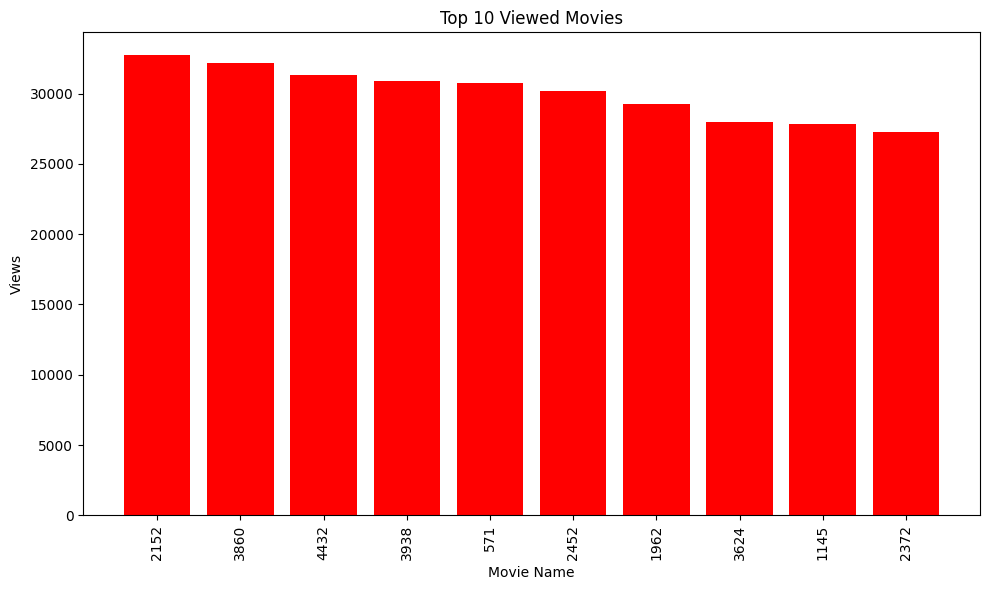

In [7]:
top_films = sorted(film_views_data, key=lambda x: x[1], reverse=True)[:10]
film_names = [x[0] for x in top_films]
view_counts = [x[1] for x in top_films]

short_film_names = [name[:15] + '...' if len(name) > 15 else name for name in film_names]

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(short_film_names, view_counts, color='red')
ax.set_xlabel('Movie Name')
ax.set_ylabel('Views')
ax.set_title('Top 10 Viewed Movies')
ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

This cell graphs the top 10 users who watched the most movies.

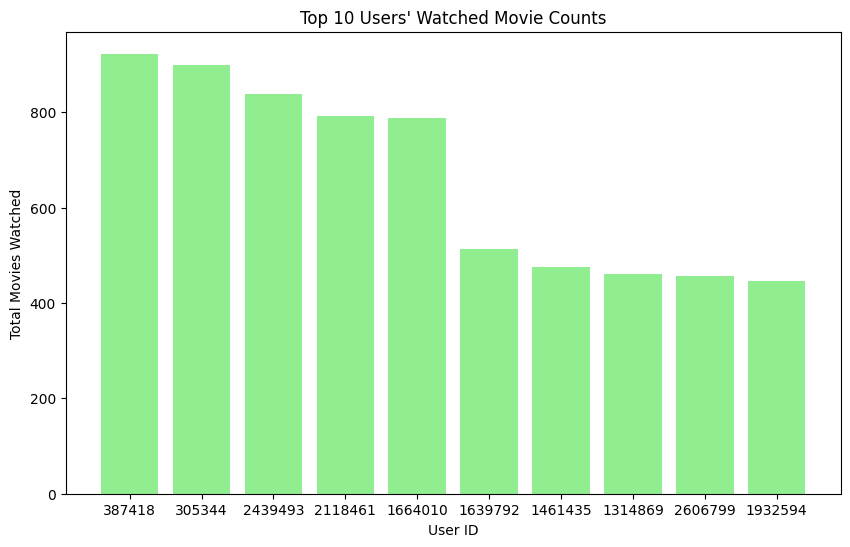

In [9]:
user_movie_counts = sampled_rdd.map(lambda x: (x[1][0][0], 1))

user_movie_totals = user_movie_counts.reduceByKey(lambda a, b: a + b)

results = user_movie_totals.collect()

sorted_results = sorted(results, key=lambda x: x[1], reverse=True)
top_users = sorted_results[:10]
users = [x[0] for x in top_users]
movie_counts = [x[1] for x in top_users]

plt.figure(figsize=(10, 6))
plt.bar(users, movie_counts, color='lightgreen')
plt.xlabel('User ID')
plt.ylabel('Total Movies Watched')
plt.title('Top 10 Users\' Watched Movie Counts')
plt.show()

This cell graphs the top 10 rated movies with movie names.

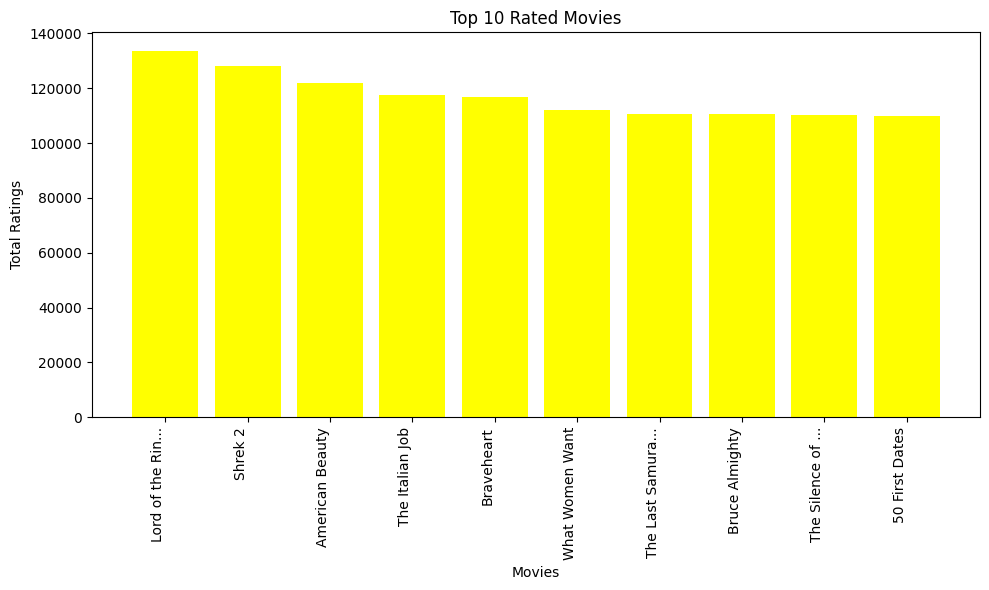

In [10]:
movie_ratings = sampled_rdd.map(lambda x: (x[0], x[1][0][1]))

movie_total_ratings = movie_ratings.reduceByKey(lambda a, b: a + b)

sorted_movies = movie_total_ratings.sortBy(lambda x: x[1], ascending=False)

sorted_movies_list = sorted_movies.take(10)

movie_names = sampled_rdd.map(lambda x: (x[0], shorten_name(x[1][1]))).distinct().collectAsMap()
results = [(movie_names[movie_id], total_rating) for movie_id, total_rating in sorted_movies_list]

movies, ratings = zip(*results)
plt.figure(figsize=(10, 6))
plt.bar(movies, ratings, color='yellow')
plt.xlabel('Movies')
plt.ylabel('Total Ratings')
plt.title('Top 10 Rated Movies')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

This cell calculate each movie's average rating values and count separating categories and draw this information.

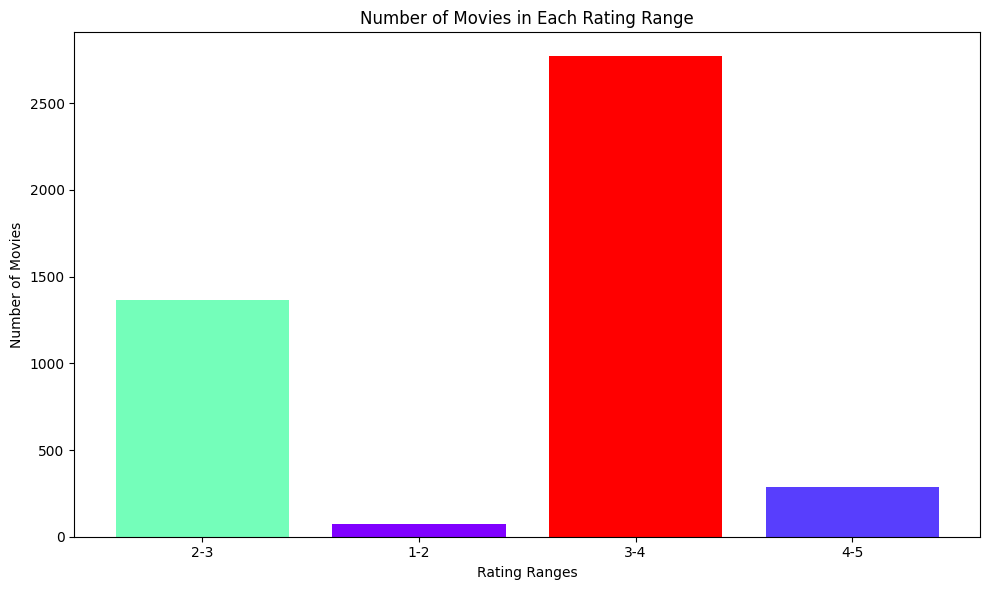

In [12]:
def categorize_rating(rating):
    if 0 <= rating < 1:
        return "0-1"
    elif 1 <= rating < 2:
        return "1-2"
    elif 2 <= rating < 3:
        return "2-3"
    elif 3 <= rating < 4:
        return "3-4"
    elif 4 <= rating < 5:
        return "4-5"
    else:
        return "Invalid"

movie_ratings = sampled_rdd.map(lambda x: (x[0], x[1][0][1]))

movie_rating_counts = movie_ratings.aggregateByKey(
    (0, 0),
    lambda acc, rating: (acc[0] + rating, acc[1] + 1),
    lambda acc1, acc2: (acc1[0] + acc2[0], acc1[1] + acc2[1])
)

movie_avg_ratings = movie_rating_counts.mapValues(lambda x: x[0] / x[1])

sorted_avg_ratings = movie_avg_ratings.sortBy(lambda x: x[1], ascending=False)

sorted_avg_ratings_list = sorted_avg_ratings.collect()

movie_names = sampled_rdd.map(lambda x: (x[0], shorten_name(x[1][1]))).distinct().collectAsMap()
results = [(movie_names[movie_id], avg_rating) for movie_id, avg_rating in sorted_avg_ratings_list]

ratings_categories = movie_avg_ratings.mapValues(categorize_rating)

rating_counts = ratings_categories.map(lambda x: (x[1], 1)) \
                                  .reduceByKey(lambda x, y: x + y)

categories, counts = zip(*rating_counts.collect())

# Normalize edilmiş değerler ile renkleri oluştur
norm = plt.Normalize(min(counts), max(counts))  # Normalize et
colors = plt.cm.rainbow(norm(counts))  # Renk haritası uygula

# Bar grafiği çiz
plt.figure(figsize=(10, 6))
plt.bar(categories, counts, color=colors)
plt.xlabel('Rating Ranges')
plt.ylabel('Number of Movies')
plt.title('Number of Movies in Each Rating Range')
plt.tight_layout()
plt.show()

- This cell draw correlation between average rating and view count for each movie.
- As a result, there is not correlation between average rating and view count for our dataset.

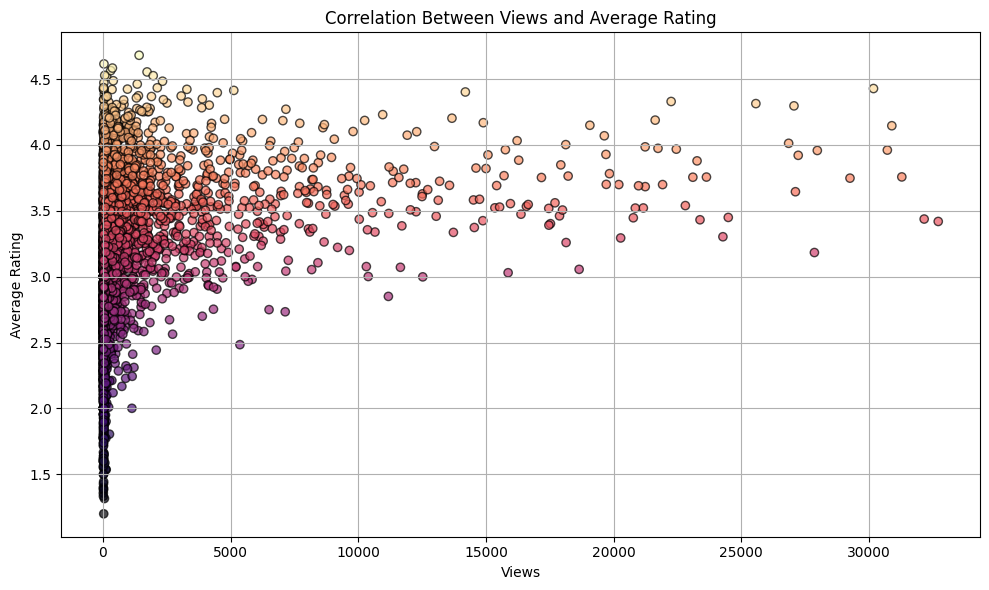

In [13]:
movie_ratings = sampled_rdd.map(lambda x: (x[0], x[1][0][1]))

movie_rating_counts = movie_ratings.aggregateByKey(
    (0, 0),
    lambda acc, rating: (acc[0] + rating, acc[1] + 1),
    lambda acc1, acc2: (acc1[0] + acc2[0], acc1[1] + acc2[1])
)

movie_avg_ratings = movie_rating_counts.mapValues(lambda x: (x[0] / x[1], x[1]))

movie_avg_ratings_list = movie_avg_ratings.collect()

movie_names = sampled_rdd.map(lambda x: (x[0], shorten_name(x[1][1]))).distinct().collectAsMap()
results = [
    (movie_names[movie_id], avg_rating, vote_count)
    for movie_id, (avg_rating, vote_count) in movie_avg_ratings_list
]

movies, avg_ratings, vote_counts = zip(*results)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(vote_counts, avg_ratings, c=avg_ratings, cmap='magma', alpha=0.7, edgecolors='k')
plt.xlabel('Views')
plt.ylabel('Average Rating')
plt.title('Correlation Between Views and Average Rating')
plt.grid(True)
plt.tight_layout()
plt.show()